# Some Plotting of the predictions obtained with Linear

In [21]:
import os 

import urllib.request

import pickle
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

# Dati Aggiornati giorno per giorno
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

# Load historical data from local file
df_full = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding='ISO-8859-1',
                 dtype={'RegionName': str,
                        'RegionCode': str},
                 error_bad_lines=False)

# For testing, restrict training data to that before a hypothetical predictor submission date
# Restringe il training-testing al 31 luglio 2020, data IPOTETICA di consegna del modello
# Nel nostro caso sarà 2020-12-22
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64('2020-07-31')
df = df_full[df_full.Date <= HYPOTHETICAL_SUBMISSION_DATE]

# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)
df_full['GeoID'] = df_full['CountryName'] + '__' + df_full['RegionName'].astype(str)

# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)
df_full['NewCases'] = df_full.groupby('GeoID').ConfirmedCases.diff().fillna(0)

# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']

cases_col = ['NewCases']

npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']

df_full = df_full[id_cols + cases_col + npi_cols]
df = df[id_cols + cases_col + npi_cols]

# Fill any missing case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))
df_full.update(df_full.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

# Fill any missing NPIs by assuming they are the same as previous day
for npi_col in npi_cols:
    df.update(df.groupby('GeoID')[npi_col].ffill().fillna(0))
    df_full.update(df_full.groupby('GeoID')[npi_col].ffill().fillna(0))

<ipython-input-21-2250c4c909d4>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)
<ipython-input-21-2250c4c909d4>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)


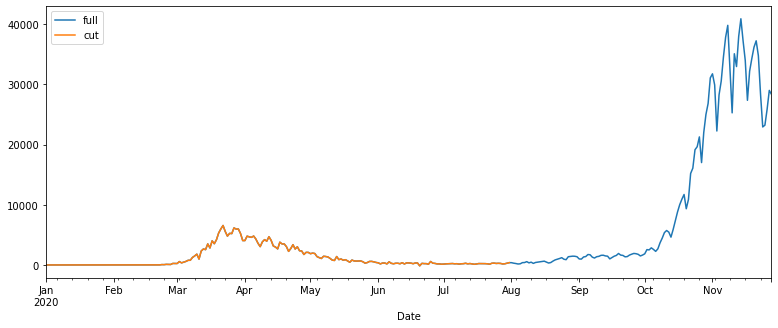

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

geo = 'Italy__nan'  # nan, dato che Italy non ha sotto-regioni

for data, label in zip([df_full, df], ['full', 'cut']):
  data[data.GeoID == geo].plot(y='NewCases', x='Date', ax=ax, label=label)

# Sono perfettamente sovrapposti fino a fine luglio, Dopodichè tengo solo quello intero.

In [27]:
# Ora vorrei fare la stessa cosa del plot precedente, con la prediction del modello lineare

MODEL_FILE = os.path.join('models', 'model.pkl')

# Load model
with open(MODEL_FILE, 'rb') as model_file:
  model = pickle.load(model_file)

Lasso(alpha=0.1, max_iter=10000, positive=True, precompute=True,
      selection='random')

In [39]:
# Siccome li ho già predetti nell'altro notebook, carichiamo le previsioni per i 30 giorni di agosto

pred = pd.read_csv(os.path.join('predictions', 'try_1_month.csv'))
df_full[df_full.CountryName == 'Italy' and df_full.Date <= ]
pred[pred.CountryName == 'Italy']

,CountryName,RegionName,Date,PredictedDailyNewCases
2550,Italy,NaN,2020-08-01,28779.355987
2551,Italy,NaN,2020-08-02,26326.876759
2552,Italy,NaN,2020-08-03,26233.450405
2553,Italy,NaN,2020-08-04,27821.739892
2554,Italy,NaN,2020-08-05,29497.978169
2555,Italy,NaN,2020-08-06,29688.874476
2556,Italy,NaN,2020-08-07,29949.191877
2557,Italy,NaN,2020-08-08,28885.843318
2558,Italy,NaN,2020-08-09,28834.360312
2559,Italy,NaN,2020-08-10,29801.314853


30


ConversionError: Failed to convert value(s) to axis units: array([Period('2020-08-01', 'D'), Period('2020-08-02', 'D'),
       Period('2020-08-03', 'D'), Period('2020-08-04', 'D'),
       Period('2020-08-05', 'D'), Period('2020-08-06', 'D'),
       Period('2020-08-07', 'D'), Period('2020-08-08', 'D'),
       Period('2020-08-09', 'D'), Period('2020-08-10', 'D'),
       Period('2020-08-11', 'D'), Period('2020-08-12', 'D'),
       Period('2020-08-13', 'D'), Period('2020-08-14', 'D'),
       Period('2020-08-15', 'D'), Period('2020-08-16', 'D'),
       Period('2020-08-17', 'D'), Period('2020-08-18', 'D'),
       Period('2020-08-19', 'D'), Period('2020-08-20', 'D'),
       Period('2020-08-21', 'D'), Period('2020-08-22', 'D'),
       Period('2020-08-23', 'D'), Period('2020-08-24', 'D'),
       Period('2020-08-25', 'D'), Period('2020-08-26', 'D'),
       Period('2020-08-27', 'D'), Period('2020-08-28', 'D'),
       Period('2020-08-29', 'D'), Period('2020-08-30', 'D')], dtype=object)

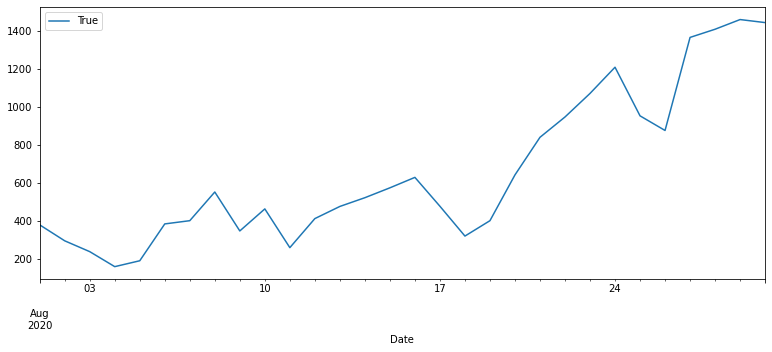

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

geo = 'Italy__nan'  # nan, dato che Italy non ha sotto-regioni

Country_mask = df_full.CountryName == 'Italy'
Date_mask = (df_full.Date >= '2020-08-01') & (df_full.Date <= '2020-08-30')

true = df_full[Country_mask & Date_mask]

print(len(true))

true.plot(y='NewCases', x='Date', ax=ax, label='True')
pred.plot(y='PredictedDailyNewCases', x='Date', label='Predicted', ax=ax)
